## 2D Remesh Trial

Initialize 10x10 square mesh, and `V_src` function space.

Define a simple function `f_src` that is just `f(x,y) = x + y`.

In [2]:
import firedrake
import matplotlib.pyplot as plt
import numpy as np
import icepack
import icepack.plot

src_mesh = firedrake.UnitSquareMesh(10,10)
src_mesh.coordinates.dat.data_wo[:] *= 10
x_src, y_src = firedrake.SpatialCoordinate(src_mesh)
V_src = firedrake.FunctionSpace(src_mesh, "CG", 2)

from firedrake import sin, sqrt
# f_src = firedrake.Function(V_src).interpolate(sin(sqrt(x_src**2 + y_src**2)*2*3.14159)+1)
f_src = firedrake.Function(V_src).interpolate(x_src + y_src)

Plot function and check that `f(1,1) = 2` and `f(3,4) = 7`.

1.9999999999999996
6.999999999999999


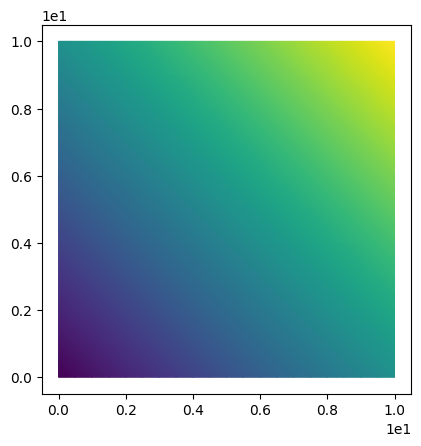

In [3]:
fig, axes = icepack.plot.subplots()
kw = {"vmin": 0, "vmax": 20}
icepack.plot.tripcolor(f_src, axes = axes, **kw);

print(f_src.at(1,1))
print(f_src.at(3,4))

Initialze a new 5x5 mesh, a function space `V_dest_1`.

Interpolate `f_src` onto `V_dest_1` to get `f_dest_1`.

In [4]:
dest_mesh_1 = firedrake.UnitSquareMesh(10,10, quadrilateral=True)
dest_mesh_1.coordinates.dat.data_wo[:] *= 5

V_dest_1 = firedrake.FunctionSpace(dest_mesh_1,"Q",2)
f_dest_1 = firedrake.interpolate(f_src, V_dest_1)

Plot result to check that the function was transferred properly, and check that function is evaluated correctly at test points.

1.9999999999999996
6.999999999999999


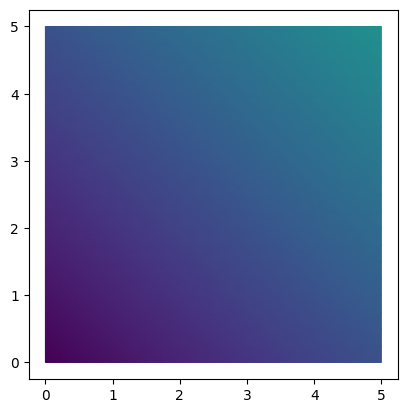

In [5]:
fig, axes = icepack.plot.subplots()
kw = {"vmin": 0, "vmax": 20}
icepack.plot.tripcolor(f_dest_1, axes = axes, **kw);

print(f_src.at(1,1))
print(f_src.at(3,4))

Initialze a new 20x20 mesh, a function space `V_dest_2`.

Interpolate `f_src` onto `V_dest_2` to get `f_dest_2`. Allow missing values and fill those with a default value of `1`.

In [6]:
dest_mesh_2 = firedrake.UnitSquareMesh(10,10, quadrilateral = True)
dest_mesh_2.coordinates.dat.data_wo[:] *= 20

V_dest_2 = firedrake.FunctionSpace(dest_mesh_2,"Q",2)
f_dest_2 = firedrake.interpolate(f_src, V_dest_2, allow_missing_dofs=True, default_missing_val=1)

Plot result to check that the function was transferred properly, and check that function is evaluated correctly at test points. 

1.9999999999999996
6.999999999999999


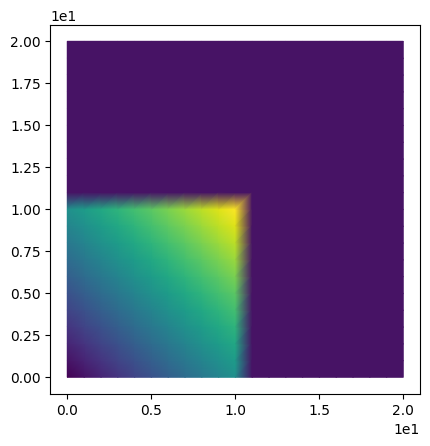

In [7]:
fig, axes = icepack.plot.subplots()
kw = {"vmin": 0, "vmax": 20}
icepack.plot.tripcolor(f_dest_2, axes = axes, **kw);

print(f_src.at(1,1))
print(f_src.at(3,4))

## 1D Remesh Trial

Initialize an `IntervalMesh`, scalar and vector functions spaces.

Extract the `SpatialCoordinate`.

Initialize simple 1D scalar function `f_src_1`, and 1D vector function `u_src_1`.

In [22]:
src_mesh1d = firedrake.IntervalMesh(10, 10)
src_mesh_1 = firedrake.ExtrudedMesh(src_mesh1d, layers=1)

Q_src_1 = firedrake.FunctionSpace(src_mesh_1, "CG", 2, vfamily="R", vdegree = 0)
V_src_1 = firedrake.FunctionSpace(src_mesh_1, "CG", 2, vfamily="GL", vdegree = 2)

x, z = firedrake.SpatialCoordinate(src_mesh_1)

f_src_1 = firedrake.interpolate(x, Q_src_1)
u_src_1 = firedrake.interpolate(x**2/10, V_src_1) 

Plot the functions.

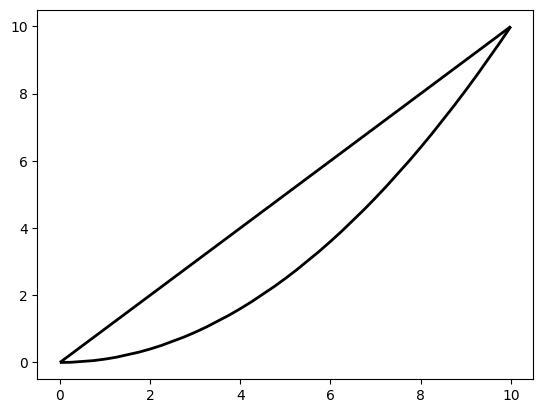

In [23]:
fig, axes = plt.subplots()
firedrake.plot(icepack.depth_average(f_src_1), axes=axes);
firedrake.plot(icepack.depth_average(u_src_1), axes = axes);

#### Setup Base Mesh

Extract function coordinates into `f_data`.

Initialize `x_mesh` as an np.linspace array https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy-linspace

Initialize `interp1d` object `f_interpolator`, based on 1D array `x_mesh`, ND array `f_data`, use linear interpolation (but it could be other types), and allow interpolation to values outside of the mesh.

Do the same for the velocity function `u_src_1`.

In [24]:
from scipy.interpolate import interp1d
import xarray

f_data = f_src_1.dat.data
x_mesh = np.linspace(0,10,len(f_data),endpoint=True)
f_interpolator = interp1d(x_mesh, f_data, kind='linear', bounds_error=False, fill_value=0)

u_data = u_src_1.dat.data
u_mesh = np.linspace(0,10,len(u_data), endpoint=True)
u_interpolator = interp1d(u_mesh, u_data, kind='linear', bounds_error=False, fill_value=0)

#### Shrink Mesh - Scalar Values

Initialize a mesh of the size you want, `x_mesh_3`, and interpolate the values using the `interp1d` object `f_interpolator`.

Save interpolated values to `f_data_3`.

Wrap `f_data_3` as a `xarray.DataArray`, using the coordinates from `x_mesh_3`, and naming the one dimension as 'x'.

In [12]:
x_mesh_3 = np.linspace(0,5,len(f_data),endpoint=True)

f_data_3 = f_interpolator(x_mesh_3)
tmp = xarray.DataArray(f_data_3, [x_mesh_3],'x')

# print(f_data_3)

Initialize destination meshes, function spaces.

Use the `DataArray` from above (`tmp`) to interpolate onto the scalar function space `Q_dest_3`.

In [13]:
dest_mesh1d_3 = firedrake.IntervalMesh(10, 5)
dest_mesh_3 = firedrake.ExtrudedMesh(dest_mesh1d_3, layers=1)

x_3, z_3 = firedrake.SpatialCoordinate(dest_mesh_3)
Q_dest_3 = firedrake.FunctionSpace(dest_mesh_3, "CG", 2, vfamily="R", vdegree=0)
V_dest_3 = firedrake.FunctionSpace(dest_mesh_3, "CG", 2, vfamily="GL", vdegree=2)

f_dest_3 = icepack.interpolate(tmp, Q_dest_3)

Plot the results. The start of the curve looks strange, it appears that the first two values in the array are swapped. Maybe this can be manually corrected.

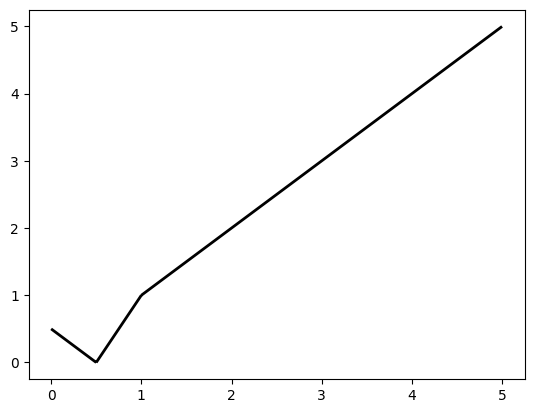

In [14]:
fig, axes = plt.subplots()
firedrake.plot(icepack.depth_average(f_dest_3), axes=axes);

#### Shrink Mesh - Vector Values

In [32]:
u_mesh_3 = np.linspace(0,5,len(u_data),endpoint=True)

u_data_3 = f_interpolator(u_mesh_3)
u_tmp_3 = xarray.DataArray(u_data_3, [u_mesh_3],'x')

In [33]:
u_dest_3 = icepack.interpolate(u_tmp_3, V_dest_3)

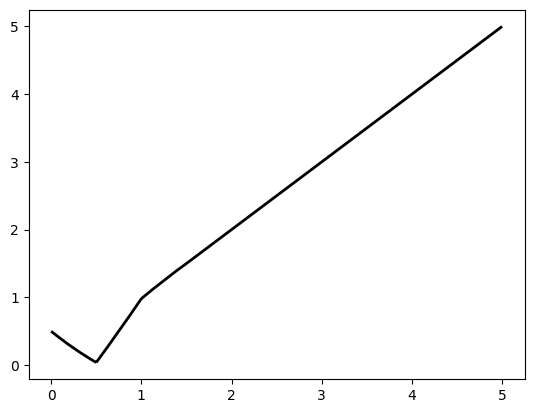

In [34]:
fig, axes = plt.subplots()
firedrake.plot(icepack.depth_average(u_dest_3), axes=axes);

#### Extend Mesh

In [ ]:
x_mesh_5 = np.linspace(0,20,len(f_data),endpoint=True)

f_data_5 = f_interpolator(x_mesh_5)
tmp = xarray.DataArray(f_data_5, [x_mesh_5],'x')

In [ ]:
dest_mesh1d_5 = firedrake.IntervalMesh(10, 20)
dest_mesh_5 = firedrake.ExtrudedMesh(dest_mesh1d_5, layers=1)

x_5, z_5 = firedrake.SpatialCoordinate(dest_mesh_5)
Q_dest_5 = firedrake.FunctionSpace(dest_mesh_5, "CG", 2, vfamily="R", vdegree=0)
V_dest_5 = firedrake.FunctionSpace(dest_mesh_5, "CG", 2, vfamily="GL", vdegree=2)

f_dest_5 = icepack.interpolate(tmp, Q_dest_5)

In [ ]:
fig, axes = plt.subplots()
firedrake.plot(icepack.depth_average(f_dest_5), axes=axes);